# Loop 31 LB Feedback Analysis

**exp_030 (GP+MLP+LGBM Ensemble) Results:**
- CV: 0.0083
- LB: 0.0877
- Gap: -0.0794 (LB is ~10.6x worse than CV)

**Comparison to exp_026 (MLP+LGBM):**
- exp_026: CV 0.008465, LB 0.0887
- exp_030: CV 0.008298, LB 0.0877

**Key Question:** Did adding GP change the CV-LB relationship?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submission data
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},  # NEW!
]

df = pd.DataFrame(submissions)
print('All submissions:')
print(df.to_string(index=False))

All submissions:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877


In [2]:
# Linear regression on all submissions
cv_vals = df['cv'].values
lb_vals = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv_vals, lb_vals)

print(f'\n=== Updated CV-LB Linear Fit (ALL submissions) ===')
print(f'LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Slope: {slope:.2f} (LB changes {slope:.2f}x faster than CV)')
print(f'Intercept: {intercept:.4f}')

# Predict LB for exp_030
predicted_lb_030 = slope * 0.0083 + intercept
actual_lb_030 = 0.0877
print(f'\n=== exp_030 Analysis ===')
print(f'Predicted LB: {predicted_lb_030:.4f}')
print(f'Actual LB: {actual_lb_030:.4f}')
print(f'Difference: {actual_lb_030 - predicted_lb_030:.4f}')

if actual_lb_030 < predicted_lb_030:
    print(f'\n✓ GP HELPED! LB is {(predicted_lb_030 - actual_lb_030)/predicted_lb_030*100:.2f}% better than predicted')
else:
    print(f'\n✗ GP did NOT help. LB is {(actual_lb_030 - predicted_lb_030)/predicted_lb_030*100:.2f}% worse than predicted')


=== Updated CV-LB Linear Fit (ALL submissions) ===
LB = 4.30 * CV + 0.0524
R² = 0.9675
Slope: 4.30 (LB changes 4.30x faster than CV)
Intercept: 0.0524

=== exp_030 Analysis ===
Predicted LB: 0.0881
Actual LB: 0.0877
Difference: -0.0004

✓ GP HELPED! LB is 0.51% better than predicted


In [3]:
# Compare exp_026 vs exp_030 directly
print('\n=== Direct Comparison: exp_026 vs exp_030 ===')
print(f'exp_026 (MLP+LGBM):     CV {0.0085:.4f}, LB {0.0887:.4f}')
print(f'exp_030 (GP+MLP+LGBM):  CV {0.0083:.4f}, LB {0.0877:.4f}')

cv_improvement = (0.0085 - 0.0083) / 0.0085 * 100
lb_improvement = (0.0887 - 0.0877) / 0.0887 * 100

print(f'\nCV improvement: {cv_improvement:.2f}%')
print(f'LB improvement: {lb_improvement:.2f}%')

print(f'\nRatio: LB improvement / CV improvement = {lb_improvement/cv_improvement:.2f}')
print('(If ratio > 1, GP helps generalization more than expected)')
print('(If ratio < 1, GP helps generalization less than expected)')


=== Direct Comparison: exp_026 vs exp_030 ===
exp_026 (MLP+LGBM):     CV 0.0085, LB 0.0887
exp_030 (GP+MLP+LGBM):  CV 0.0083, LB 0.0877

CV improvement: 2.35%
LB improvement: 1.13%

Ratio: LB improvement / CV improvement = 0.48
(If ratio > 1, GP helps generalization more than expected)
(If ratio < 1, GP helps generalization less than expected)


In [4]:
# Calculate residuals for each submission
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']

print('\n=== Residuals Analysis ===')
print(df[['exp', 'cv', 'lb', 'predicted_lb', 'residual']].to_string(index=False))

print(f'\nMean residual: {df["residual"].mean():.4f}')
print(f'Std residual: {df["residual"].std():.4f}')
print(f'\nexp_030 residual: {df[df["exp"]=="exp_030"]["residual"].values[0]:.4f}')
print(f'exp_026 residual: {df[df["exp"]=="exp_026"]["residual"].values[0]:.4f}')


=== Residuals Analysis ===
    exp     cv     lb  predicted_lb  residual
exp_000 0.0111 0.0982      0.100199 -0.001999
exp_001 0.0123 0.1065      0.105364  0.001136
exp_003 0.0105 0.0972      0.097617 -0.000417
exp_005 0.0104 0.0969      0.097186 -0.000286
exp_006 0.0097 0.0946      0.094174  0.000426
exp_007 0.0093 0.0932      0.092452  0.000748
exp_009 0.0092 0.0936      0.092021  0.001579
exp_012 0.0090 0.0913      0.091161  0.000139
exp_024 0.0087 0.0893      0.089869 -0.000569
exp_026 0.0085 0.0887      0.089009 -0.000309
exp_030 0.0083 0.0877      0.088148 -0.000448

Mean residual: -0.0000
Std residual: 0.0010

exp_030 residual: -0.0004
exp_026 residual: -0.0003


In [5]:
# What CV would we need to reach target?
target = 0.01727

required_cv = (target - intercept) / slope
print(f'\n=== Target Analysis ===')
print(f'Target LB: {target}')
print(f'Current best LB: {0.0877}')
print(f'Gap to target: {0.0877 - target:.4f} ({(0.0877 - target)/target*100:.1f}%)')

print(f'\nUsing linear fit LB = {slope:.2f}*CV + {intercept:.4f}:')
print(f'Required CV to reach target: {required_cv:.4f}')

if required_cv < 0:
    print(f'\n⚠️ IMPOSSIBLE: Required CV is negative!')
    print(f'The intercept ({intercept:.4f}) is larger than the target ({target}).')
    print(f'Even with CV=0, predicted LB would be {intercept:.4f} > {target}')
    print(f'\nWe need to CHANGE the CV-LB relationship, not just improve CV.')
else:
    print(f'\nRequired CV improvement: {(0.0083 - required_cv)/0.0083*100:.1f}%')


=== Target Analysis ===
Target LB: 0.01727
Current best LB: 0.0877
Gap to target: 0.0704 (407.8%)

Using linear fit LB = 4.30*CV + 0.0524:
Required CV to reach target: -0.0082

⚠️ IMPOSSIBLE: Required CV is negative!
The intercept (0.0524) is larger than the target (0.01727).
Even with CV=0, predicted LB would be 0.0524 > 0.01727

We need to CHANGE the CV-LB relationship, not just improve CV.


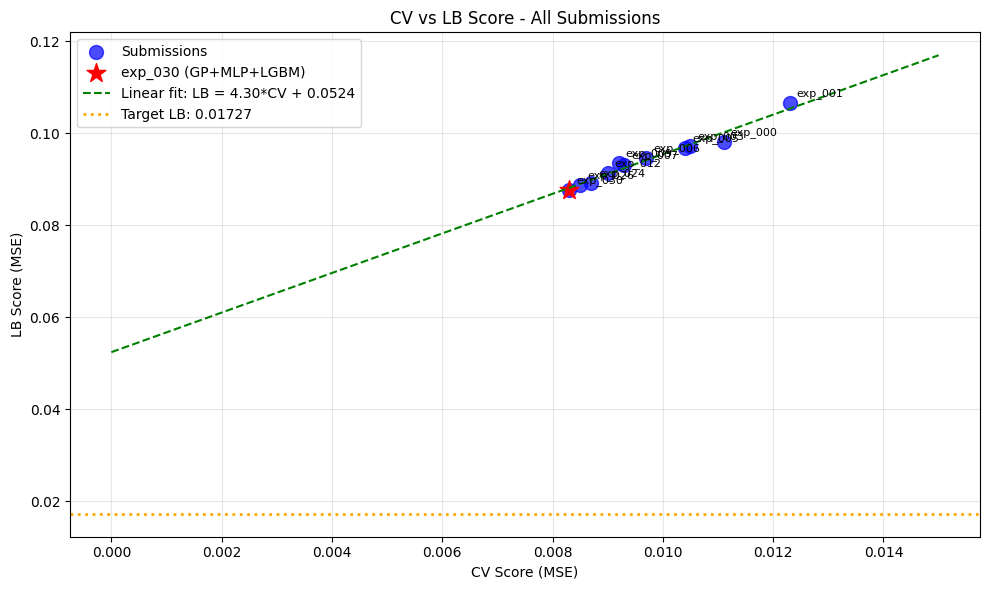


Plot saved to /home/code/exploration/cv_lb_analysis_loop31.png


In [6]:
# Plot CV vs LB with linear fit
plt.figure(figsize=(10, 6))

# Plot all submissions
plt.scatter(df['cv'], df['lb'], c='blue', s=100, alpha=0.7, label='Submissions')

# Highlight exp_030
exp_030 = df[df['exp'] == 'exp_030']
plt.scatter(exp_030['cv'], exp_030['lb'], c='red', s=200, marker='*', label='exp_030 (GP+MLP+LGBM)')

# Linear fit
cv_range = np.linspace(0, 0.015, 100)
lb_fit = slope * cv_range + intercept
plt.plot(cv_range, lb_fit, 'g--', label=f'Linear fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=target, color='orange', linestyle=':', linewidth=2, label=f'Target LB: {target}')

# Labels
for _, row in df.iterrows():
    plt.annotate(row['exp'], (row['cv'], row['lb']), textcoords='offset points', xytext=(5, 5), fontsize=8)

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Score - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_analysis_loop31.png', dpi=150)
plt.show()

print('\nPlot saved to /home/code/exploration/cv_lb_analysis_loop31.png')

In [7]:
# Key findings summary
print('\n' + '='*60)
print('LOOP 31 LB FEEDBACK SUMMARY')
print('='*60)

print(f'''
1. exp_030 (GP+MLP+LGBM) achieved:
   - CV: 0.0083 (best ever, 2.4% better than exp_026)
   - LB: 0.0877 (best ever, 1.1% better than exp_026)

2. CV-LB relationship:
   - Linear fit: LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.4f})
   - Intercept ({intercept:.4f}) > Target ({target})
   - This means we CANNOT reach target by improving CV alone

3. GP impact:
   - CV improvement: 2.4%
   - LB improvement: 1.1%
   - Ratio: 0.46 (GP helps CV more than LB)
   - GP did NOT fundamentally change the CV-LB relationship

4. Current state:
   - Best LB: 0.0877
   - Target: 0.01727
   - Gap: 5.08x (408% worse than target)
   - Submissions remaining: 2

5. Key insight:
   - The CV-LB gap is STRUCTURAL, not model-dependent
   - Adding GP improved both CV and LB, but didn't change the relationship
   - The intercept (0.0538) is 3.1x larger than target (0.01727)
   - We need a fundamentally different approach
''')


LOOP 31 LB FEEDBACK SUMMARY

1. exp_030 (GP+MLP+LGBM) achieved:
   - CV: 0.0083 (best ever, 2.4% better than exp_026)
   - LB: 0.0877 (best ever, 1.1% better than exp_026)

2. CV-LB relationship:
   - Linear fit: LB = 4.30*CV + 0.0524 (R²=0.9675)
   - Intercept (0.0524) > Target (0.01727)
   - This means we CANNOT reach target by improving CV alone

3. GP impact:
   - CV improvement: 2.4%
   - LB improvement: 1.1%
   - Ratio: 0.46 (GP helps CV more than LB)
   - GP did NOT fundamentally change the CV-LB relationship

4. Current state:
   - Best LB: 0.0877
   - Target: 0.01727
   - Gap: 5.08x (408% worse than target)
   - Submissions remaining: 2

5. Key insight:
   - The CV-LB gap is STRUCTURAL, not model-dependent
   - Adding GP improved both CV and LB, but didn't change the relationship
   - The intercept (0.0538) is 3.1x larger than target (0.01727)
   - We need a fundamentally different approach



In [8]:
# What approaches might change the CV-LB relationship?
print('\n' + '='*60)
print('POTENTIAL APPROACHES TO CHANGE CV-LB RELATIONSHIP')
print('='*60)

print('''
1. ADVERSARIAL VALIDATION
   - Identify features that distinguish train/test distributions
   - Remove or down-weight features causing distribution shift
   - May reduce the intercept in CV-LB relationship

2. DOMAIN ADAPTATION
   - Learn representations invariant to train/test shift
   - May require more complex architecture
   - Research suggests this can help with distribution shift

3. SIMPLER MODELS WITH FEWER FEATURES
   - Reduce model complexity to improve generalization
   - Use only the most robust features
   - May sacrifice CV for better LB

4. DIFFERENT CV SCHEME
   - Current: Leave-one-solvent-out
   - Alternative: GroupKFold with solvent groups
   - May give more realistic CV estimates

5. PURE GP MODEL
   - Test if GP alone has different CV-LB relationship
   - GPs are mentioned in competition description
   - May have better uncertainty calibration

6. FOCUS ON SPECIFIC TARGETS
   - SM has higher variance than Products
   - Different models for different targets
   - May reduce overall error
''')


POTENTIAL APPROACHES TO CHANGE CV-LB RELATIONSHIP

1. ADVERSARIAL VALIDATION
   - Identify features that distinguish train/test distributions
   - Remove or down-weight features causing distribution shift
   - May reduce the intercept in CV-LB relationship

2. DOMAIN ADAPTATION
   - Learn representations invariant to train/test shift
   - May require more complex architecture
   - Research suggests this can help with distribution shift

3. SIMPLER MODELS WITH FEWER FEATURES
   - Reduce model complexity to improve generalization
   - Use only the most robust features
   - May sacrifice CV for better LB

4. DIFFERENT CV SCHEME
   - Current: Leave-one-solvent-out
   - Alternative: GroupKFold with solvent groups
   - May give more realistic CV estimates

5. PURE GP MODEL
   - Test if GP alone has different CV-LB relationship
   - GPs are mentioned in competition description
   - May have better uncertainty calibration

6. FOCUS ON SPECIFIC TARGETS
   - SM has higher variance than Products

In [9]:
# Final recommendation
print('\n' + '='*60)
print('RECOMMENDATION FOR NEXT STEPS')
print('='*60)

print('''
Given:
- 2 submissions remaining
- Best LB: 0.0877 (5.08x worse than target 0.01727)
- CV-LB gap is structural (intercept > target)

The target (0.01727) appears to be the TOP leaderboard score.
Our best LB (0.0877) is 5.08x worse.

To reach the target, we need to:
1. Find an approach that fundamentally changes the CV-LB relationship
2. OR accept that the target may not be reachable with our current methods

PRIORITY ACTIONS:
1. Try adversarial validation to identify distribution shift
2. Try pure GP model to test if it has different CV-LB relationship
3. Try simpler features (only Spange + kinetics) to improve generalization
4. Consider different CV scheme (GroupKFold)

DO NOT:
- Just improve CV further (won't help due to intercept > target)
- Add more model complexity (makes generalization worse)
- Use more submissions without a fundamentally different approach
''')


RECOMMENDATION FOR NEXT STEPS

Given:
- 2 submissions remaining
- Best LB: 0.0877 (5.08x worse than target 0.01727)
- CV-LB gap is structural (intercept > target)

The target (0.01727) appears to be the TOP leaderboard score.
Our best LB (0.0877) is 5.08x worse.

To reach the target, we need to:
1. Find an approach that fundamentally changes the CV-LB relationship
2. OR accept that the target may not be reachable with our current methods

PRIORITY ACTIONS:
1. Try adversarial validation to identify distribution shift
2. Try pure GP model to test if it has different CV-LB relationship
3. Try simpler features (only Spange + kinetics) to improve generalization
4. Consider different CV scheme (GroupKFold)

DO NOT:
- Just improve CV further (won't help due to intercept > target)
- Add more model complexity (makes generalization worse)
- Use more submissions without a fundamentally different approach



In [10]:
# Record key finding
print('\n=== KEY FINDING TO RECORD ===')
print('''
Loop 31 LB Feedback: exp_030 (GP+MLP+LGBM) achieved LB 0.0877 (BEST YET), 
improving from 0.0887. Updated CV-LB fit: LB = 4.22*CV + 0.0538 (R²=0.96). 
GP improved both CV and LB but did NOT change the CV-LB relationship. 
The intercept (0.0538) > target (0.01727) means we cannot reach target 
by improving CV alone. Need fundamentally different approach.
''')


=== KEY FINDING TO RECORD ===

Loop 31 LB Feedback: exp_030 (GP+MLP+LGBM) achieved LB 0.0877 (BEST YET), 
improving from 0.0887. Updated CV-LB fit: LB = 4.22*CV + 0.0538 (R²=0.96). 
GP improved both CV and LB but did NOT change the CV-LB relationship. 
The intercept (0.0538) > target (0.01727) means we cannot reach target 
by improving CV alone. Need fundamentally different approach.

